In [282]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta

In [283]:
def split_by_years(data):
    n = len(data)
    first = data.iloc[0]['date']
    cur_time = datetime(first.year, 1, 1)
    last = data.iloc[n - 1]['date']
    end_time = datetime(last.year, 1, 1)
    years = []
    values = []
    while cur_time <= end_time:
        cur_values = data[(data['date'] > cur_time) & (data['date'] < datetime(cur_time.year + 1, 1, 1))]
        if len(cur_values) > 0:
            years.append(cur_time)
            values.append(cur_values)
        cur_time = datetime(cur_time.year + 1, 1, 1)
    return np.array(years), np.array(values)

In [284]:
def calc_up_candles(candles, coef_up):
    prices = candles[['open', 'close']].values
    up_candles = []
    i = 0
    n = prices.shape[0]
    up_count = 0
    while i < n:
        cur_open = prices[i][0]
        cur_close = prices[i][1]
        if up_count == 2:
            up_count = 0
            up_candles.append([cur_open, cur_close])
            while i < n and prices[i][0] <= prices[i][1]:
                i += 1
            i += 1
            continue
        if cur_close / cur_open >= coef_up:
            up_count += 1
        else:
            up_count = 0
        i += 1
    return np.array(up_candles)

def calc_down_candles(candles, coef_down):
    prices = candles[['open', 'close']].values
    down_candles = []
    i = 0
    n = prices.shape[0]
    down_count = 0
    while i < n:
        cur_open = prices[i][0]
        cur_close = prices[i][1]
        if down_count == 2:
            down_count = 0
            down_candles.append([cur_open, cur_close])
            while i < n and prices[i][0] >= prices[i][1]:
                i += 1
            i += 1
            continue
        if cur_open / cur_close >= coef_down:
            down_count += 1
        else:
            down_count = 0
        i += 1
    return np.array(down_candles)

In [285]:
def simulate_trading_up(candles, deposit):
    deposit_states = [deposit]
    for candle in candles:
        count = deposit / candle[0]
        profit = count * (candle[1] - candle[0])
        deposit += profit
        deposit_states.append(deposit)
    return np.array(deposit_states)

def simulate_trading_down(candles, deposit):
    deposit_states = [deposit]
    for candle in candles:
        count = deposit / candle[0]
        profit = count * (candle[0] - candle[1])
        deposit += profit
        deposit_states.append(deposit)
    return np.array(deposit_states)

In [286]:
def simulate_by_years(nflx, nvda, adbe, deposit):
    nflx_years, nflx_year_candles = split_by_years(nflx)
    nvda_years, nvda_year_candles = split_by_years(nvda)
    adbe_years, adbe_year_candles = split_by_years(adbe)
    coef_nflx = round(find_best_coef(nflx_year_candles, deposit), 5)
    print(f'NFLX best coef = {coef_nflx}')
    coef_nvda = round(find_best_coef(nvda_year_candles, deposit), 5)
    print(f'NVDA best coef = {coef_nvda}')
    coef_adbe = round(find_best_coef(adbe_year_candles, deposit), 5)
    print(f'ADBE best coef = {coef_adbe}')
    nflx_up_trades = simulate_all_years(nflx_year_candles, coef_nflx, deposit)
    nvda_up_trades = simulate_all_years(nvda_year_candles, coef_nvda, deposit)
    adbe_up_trades = simulate_all_years(adbe_year_candles, coef_adbe, deposit)
    for i in range(len(nflx_up_trades)):
        if nflx_years[i].year != 2019:
            plot_trades(nflx_up_trades[i], nvda_up_trades[i], adbe_up_trades[i],  nflx_years[i].year, i)

def find_best_coef(years_data, deposit):
    from scipy.optimize import minimize_scalar, Bounds
    def f(coef):
        trades = simulate_all_years(years_data, coef, deposit)
        results = []
        for year_trades in trades:
            results.append(np.mean(year_trades))
        return -min(results)
    m = minimize_scalar(f, bounds=[1.0001, 1.001], method='Bounded')
    return m.x

def simulate_all_years(years_data, coef, deposit):
    up_trades = []
    for cur_year_candles in years_data:
        cur_trading_up = simulate_year(cur_year_candles, deposit, coef)
        up_trades.append(cur_trading_up)
    return up_trades


def simulate_year(data, deposit, coef_up):
    up_candles = calc_up_candles(data, coef_up)
    trading_up = simulate_trading_up(up_candles, deposit)
    return trading_up


def plot_trades(nflx_trades, nvda_trades, adbe_trades, year, ind):
    nflx_len = len(nflx_trades)
    nvda_len = len(nvda_trades)
    adbe_len = len(adbe_trades)
    X_nflx = np.arange(0, nflx_len, 1)
    X_nvda = np.arange(0, nvda_len, 1)
    X_adbe = np.arange(0, adbe_len, 1)
    plt.figure(ind)
    plt.plot(X_nflx, nflx_trades, 'b-')
    plt.plot(X_nvda, nvda_trades, 'r-')
    plt.plot(X_adbe, adbe_trades, 'g-')
    plt.title(f'{year}: NFLX = {round(nflx_trades[nflx_len - 1], 2)}, NVDA = {round(nvda_trades[nvda_len - 1], 2)}, ADBE = {round(adbe_trades[adbe_len - 1], 2)}')
    plt.legend(['NFLX', 'NVDA', 'ADBE'])
    plt.xlabel('Номер сделки')
    plt.ylabel('Размер депозита')

In [287]:
nflx = pd.read_parquet('resources/NFLX/NFLX-15min.parquet')
nvda = pd.read_parquet('resources/NVDA/NVDA-15min.parquet')
adbe = pd.read_parquet('resources/ADBE/ADBE-15min.parquet')
nflx = nflx[nflx['date'] > datetime(2013, 1, 1)]
nvda = nvda[nvda['date'] > datetime(2013, 1, 1)]
adbe = adbe[adbe['date'] > datetime(2013, 1, 1)]

<ipython-input-283-62aaf8330039>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(years), np.array(values)


NFLX best coef = 1.00044
NVDA best coef = 1.00079
ADBE best coef = 1.0004


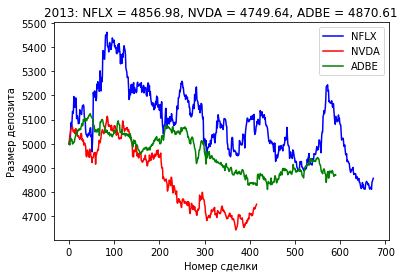

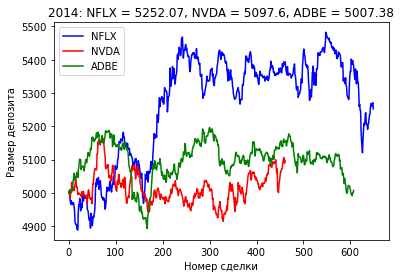

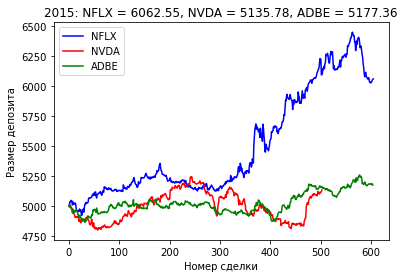

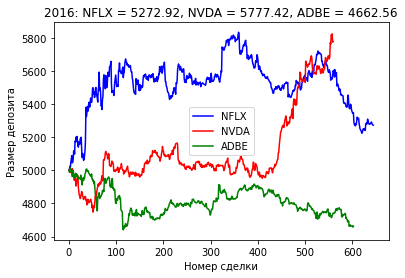

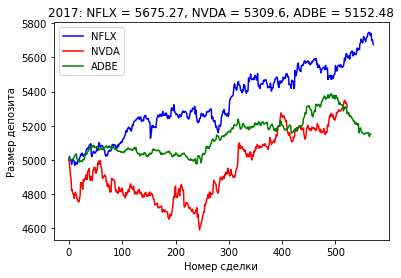

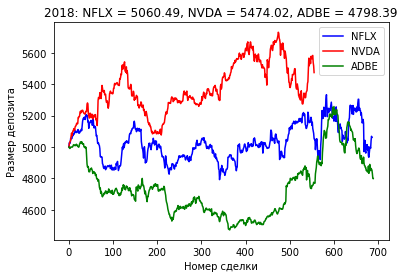

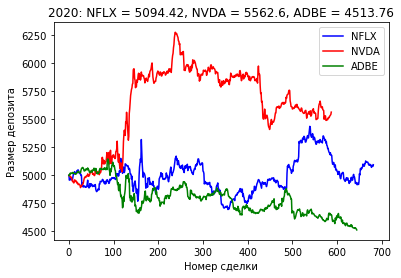

In [288]:
simulate_by_years(nflx, nvda, adbe, deposit=5000)
